# Semi Regular Polygon (3.3.3.4)

We define some scripts to create the cutting patterns for one of the 8 semi-regular tesselations.<br>
In particular for the  `triangle` + `square` tesselation defined by vertex `(3.3.3.4)`.

### Strategy

- We define a basic shape made of 1 square and 8 triangles using python library [Shapely](https://shapely.readthedocs.io/en/stable/manual.html).<br>
- We fill a portion of the plane with copies of this shape.
- We remove the polygons outside the frame which defines the shape of the riser
- We use the **Shapely** set operation "difference" to trip shapes too close to the edge (leaving some margin for welding the risers)


### Process Overview

<img src="./img/process_overview.png" >

In [2]:
# Imports
import math

from shapely.geometry import Polygon, box
from shapely import affinity, centroid, polygons

import svgwrite
from svgwrite import mm

import matplotlib.pyplot as plt
import numpy as np

### Canvas and Polygon sizes

In [3]:
# DRAWING PARAMS:
drawing_height = 300
drawing_width = 1200
tabica_height = 143.7
tabica_width = 1000

INSET_RATIO = 0.9

square_radius = 22
triangle_radius = square_radius * math.sin(math.pi/4)/math.sin(math.pi/3)

In [4]:
import sys
sys.path.append('../..')  # Add the parent directory to Python path
from polygon_utils import (
    create_regular_polygon,
    plot_polygon_dict,
    plot_polygon_list,
    blue_plot,
    center_rectangle_on_polygons,
    is_polygon_inside_frame,
    save_polygon_list_to_svg
)

### Polygon creation

In [3]:
def create_regular_polygon(center_x, center_y, radius, nr_points):
    angle = 2 * math.pi / nr_points
    polygon_points = []

    for i in range(nr_points):
        x = center_x + radius * math.cos(i * angle)
        y = center_y + radius * math.sin(i * angle)
        polygon_points.append((x, y))

    return Polygon(polygon_points)

# Create a triangle (3 sides)
triangle = create_regular_polygon(0,0,triangle_radius, 3)

# Create a square (4 sides)
square = create_regular_polygon(0,0,square_radius, 4)

### Dictionary of Polygons

Here we save a dictionary of polygons.

The reason for using a dictionary is to be able to plot polygon with its key representing its label.
This allows us to easily visualize the transforms that define the position of the polygon.

In [4]:
360/6


60.0

In [5]:
# translate_x = 0   # Translate 50mm on the X axis
# translate_y = triangle_radius/2 + square_radius*math.cos(math.pi/6)   # Translate 50mm on the Y axis

square_rotated = affinity.rotate(square, 45, origin="centroid")
triangle_up = affinity.rotate(triangle, 90, origin="centroid")
triangle_down = affinity.rotate(triangle, -90, origin="centroid")

polygon_dict = {}
polygon_dict['S0'] = square_rotated
polygon_dict['S1'] = affinity.translate(square_rotated, 2*square_radius*math.sin(math.pi/4),0)  
polygon_dict['T1'] = affinity.translate(triangle_up, 
                                        0, 
                                        triangle_radius*(math.cos(math.pi/3)) +
                                        square_radius*math.sin(math.pi/4)
                                        )

polygon_dict['T2'] = affinity.translate(triangle_down, 
                                        square_radius*math.sin(math.pi/4),
                                        2*triangle_radius*(math.cos(math.pi/3)) +
                                        square_radius*math.sin(math.pi/4)
                                        )

polygon_dict['T3'] = affinity.translate(triangle_up, 
                                        2*square_radius*math.sin(math.pi/4),
                                         triangle_radius*(math.cos(math.pi/3)) +
                                        square_radius*math.sin(math.pi/4)
                                        )


polygon_dict['T4'] = affinity.translate(triangle_down, 
                                        3*square_radius*math.sin(math.pi/4),
                                        2*triangle_radius*(math.cos(math.pi/3)) +
                                        square_radius*math.sin(math.pi/4)
                                        )


#                                  -triangle_radius*math.sin(math.pi/3),
#                                  -triangle_radius - square_radius*math.cos(math.pi/6))

# polygon_dict['T4'] = affinity.translate(triangle_down, 
#                                  0,
#                                -triangle_radius/2 - square_radius*math.cos(math.pi/6))
                                 
# polygon_dict['T5'] = affinity.translate(triangle_up,
#                                 +triangle_radius*math.sin(math.pi/3),
#                                 -triangle_radius - square_radius*math.cos(math.pi/6))                                 

# polygon_dict['T6'] = affinity.translate(triangle_down,
#                                 +2*triangle_radius*math.sin(math.pi/3),
#                                 -2*triangle_radius)

# polygon_dict['T7'] = affinity.translate(triangle_up,
#                                 +2*triangle_radius*math.sin(math.pi/3),
#                                 -triangle_radius)

# polygon_dict['T8'] = affinity.translate(triangle_down,
#                                 +3*triangle_radius*math.sin(math.pi/3),
#                                 -triangle_radius/2)

### Plotting Dictionaries of Shapes

In [6]:
def plot_polygon_dict(polygons, colors=None, alphas=None):
    """
    Function to plot a dictionary of polygons
    :param polygons: dictionary of polygons to plot
           note that keys are used as labels
    """
    fig, ax = plt.subplots(figsize=(5, 5))

    if colors is None:
        colors = plt.cm.rainbow(np.linspace(0, 1, len(polygons)))
    if alphas is None:
        alphas = [0.1] * len(polygons)

    # for polygon, color, alpha in zip(polygons, colors, alphas):
    color_idx = 0
    for key, polygon in polygons.items():
        x, y = polygon.exterior.xy
        ctr = centroid(polygon)
        ax.plot(x, y, color=colors[color_idx])
        # ax.fill(x, y, alpha=alpha, color="white")
        ax.text(ctr.x, ctr.y, key, fontsize=12, ha='center', va='center')
        color_idx += 1

    ax.axis('equal')

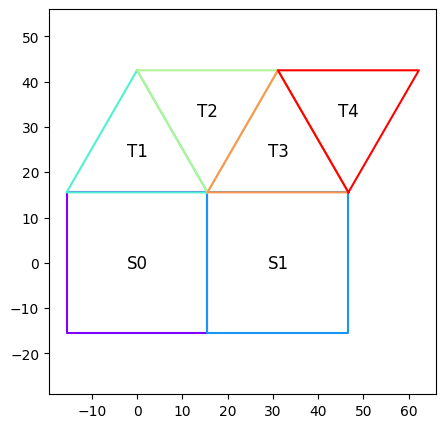

In [7]:
plot_polygon_dict(polygon_dict)

### Translations
The collection of polygons above can be translated to fill the plane as shown below:

In [8]:
# Define the translation
x_offset = 4*square_radius*math.sin(math.pi/4)
y_offset = 0 # 2*square_radius*math.sin(math.pi/4) + 2*triangle_radius*math.cos(math.pi/3)

# Translate all polygons
translated_polygons_1 = {
    f"{key}-t": affinity.translate(poly, x_offset, y_offset) for key, poly in polygon_dict.items()
}

x_offset = square_radius*math.sin(math.pi/4)  
y_offset = 2*square_radius*math.sin(math.pi/4) + 3*triangle_radius*math.cos(math.pi/3)

translated_polygons_2 = {
    f"{key}-t": affinity.translate(poly, x_offset, y_offset) for key, poly in translated_polygons_1.items()
}

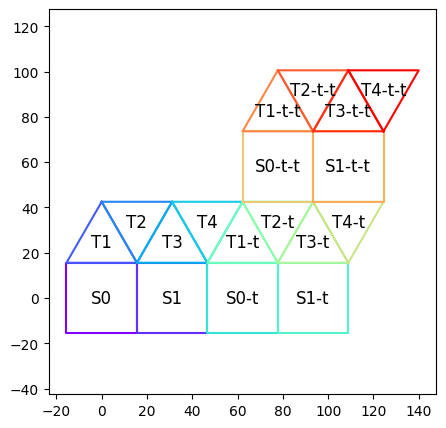

In [9]:
super_polys = { **polygon_dict, **translated_polygons_1, **translated_polygons_2}
plot_polygon_dict(super_polys)

## List of Polygons

In order to generate the full list of polygons that fill the plane, we will store them in a list
instead of a dictionary.  <br>The basic idea is to use the basic initial shape
and apply a series of translations to generate the full list of polygons.

In [10]:
initial_polygon_list = list(polygon_dict.values())

### Plane Translations

We define two translations
- Up and to the right (as shown in plot above)
- Down and to the right 

In [11]:
# Translate all polygons
def translate_polygon_right(polygon_list, nr_translations): 
    """
    takes a list of polygons and applies the "to-the-right"
    unit translation.  It returns a new list of polygons 
    with the translation applied
    """
    
    # Define the basic -> RIGHT translation
    x_right = 4*square_radius*math.sin(math.pi/4) * nr_translations
    y_right = 0 
    
    right_polygons = [
    affinity.translate(poly, x_right, y_right) for poly in polygon_list
    ]
    return right_polygons

def translate_polygon_up(polygon_list, nr_translations):
    """
    takes a list of polygons and applies the up and to the right
    unit translation.  It returns a new list of polygons 
    with the translation applied
    """
    # Define the basic DOWN + RIGHT translation
    x_up = square_radius*math.sin(math.pi/4) * nr_translations
    y_up = (2*square_radius*math.sin(math.pi/4) + 3*triangle_radius*math.cos(math.pi/3)) * nr_translations

    up_polygons = [
    affinity.translate(poly, x_up, y_up) for poly in polygon_list
    ]
    return up_polygons


### Plotting Lists of Polygons

In [12]:
def plot_polygon_list(polygons, colors=None, alphas=None):
    fig, ax = plt.subplots(figsize=(5, 5))

    if colors is None:
        colors = plt.cm.rainbow(np.linspace(0, 1, len(polygons)))
    if alphas is None:
        alphas = [0.1] * len(polygons)

    for polygon, color, alpha in zip(polygons, colors, alphas):
        x, y = polygon.exterior.xy
        ax.plot(x, y, color=color)

    ax.axis('equal')
    plt.show()

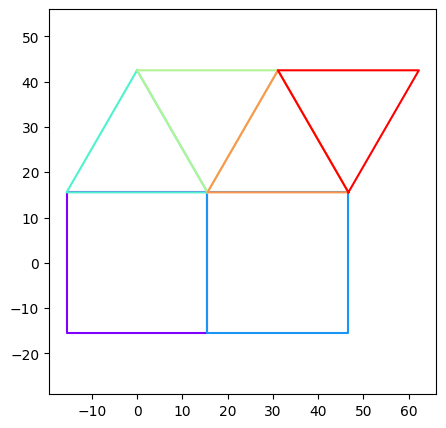

In [13]:
initial_polygon_list = list(polygon_dict.values())
plot_polygon_list(initial_polygon_list)

### Translation Strategy

1. We create a horizontal row made of copies of the "basic polygon group"
   * This row is created by translating the last copied group to the right 
   * We repeat this process until we have a big enough column (about 40 copies)

2. We then select the whole row created and make two copies translated up and right.


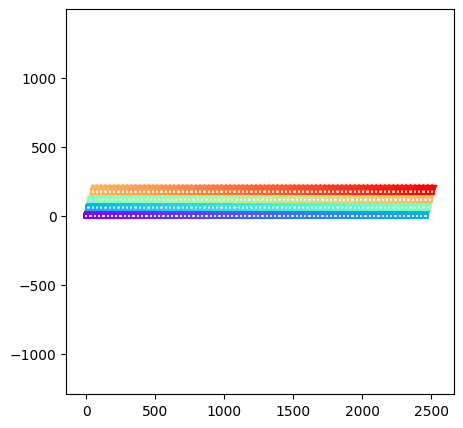

In [17]:
first_row = []
for nr_copies in range(40):
    n_copy = translate_polygon_right(initial_polygon_list, nr_copies)
    first_row += n_copy

mid_row = translate_polygon_up(first_row, 1)
mid_row_2 = translate_polygon_up(first_row, 2)
top_row = translate_polygon_up(first_row, 3)
full_poly = first_row + mid_row + mid_row_2 + top_row

plot_polygon_list(full_poly)
save_polygons_to_svg(full_poly, filename='tramo_2.1.svg')

# FRAME

The frame defines the rectangle that will become the cut sheet metal.
We want to delete polygons outside of this frame, and potentially "trim" some of the polygons at the edges,
to ensure the sheet metal can we welded robustly to the next piece.

In [18]:
frame = polygons([[0,0],
                  [0 + tabica_width, 0],
                  [0 + tabica_width, 0 + tabica_height],
                  [0, 0 + tabica_height]])

### Function to center frame around the polygons

In [19]:
def center_rectangle_on_polygons(polygons, rectangle):
    # Calculate the bounding box of all polygons
    all_polygons = Polygon()
    for poly in polygons:
        all_polygons = all_polygons.union(poly)

    polygons_bbox = all_polygons.bounds

    # Calculate centroids
    polygons_centroid = box(*polygons_bbox).centroid
    rectangle_centroid = rectangle.centroid

    # Calculate the translation needed
    dx = polygons_centroid.x - rectangle_centroid.x
    dy = polygons_centroid.y - rectangle_centroid.y

    # Apply translation to the rectangle
    centered_rectangle = affinity.translate(rectangle, dx, dy)

    return centered_rectangle

# Center the rectangle
centered_frame = center_rectangle_on_polygons(full_poly, frame)

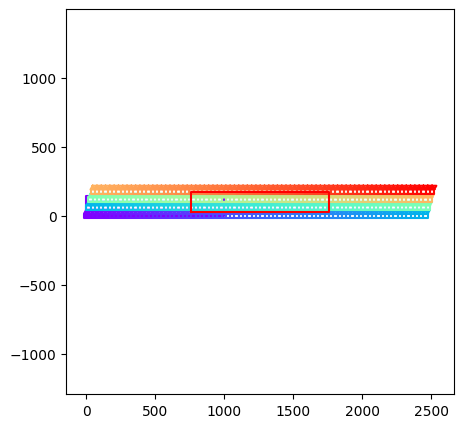

In [20]:
plot_polygon_list([frame] + full_poly + [centered_frame])

### Delete polygons *mostly* outside of frame

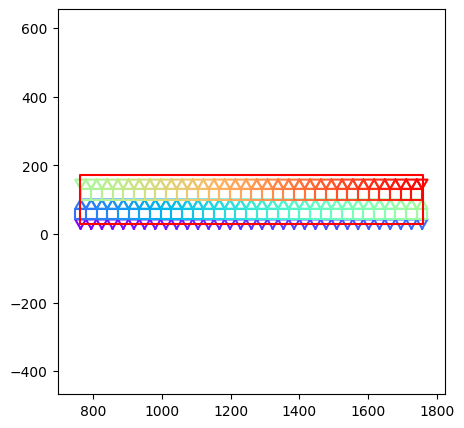

In [21]:
def is_polygon_inside_frame(polygon, rect):
    """Check if the centroid of a polygon is inside a rectangle."""
    x, y = polygon.centroid.x, polygon.centroid.y
    (rx1, ry1, rx2, ry2) = rect.bounds
    return rx1 <= x <= rx2 and ry1 <= y <= ry2

# Filter the full_polygon_list to keep only polygons "mostly" inside the rectangle
# by "mostly" we mean that the centroid of the polygon lies outside the frame.
filtered_polygon_list = [polygon for polygon in full_poly if is_polygon_inside_frame(polygon, centered_frame)]

# Update the full_polygon_list
full_poly = filtered_polygon_list

# Plot the polygons
plot_polygon_list(full_poly + [centered_frame])

## Perform Inset Operation on polygons
This shrinks each polygon to leave some material between them by a specified amount

In [22]:
INSET_DISTANCE = 3.6   # X ratio gives gaps of about 2Xmm
inset_polygon_list = []
for poly in full_poly:
    inset_polygon_list.append(poly.buffer(-INSET_DISTANCE))



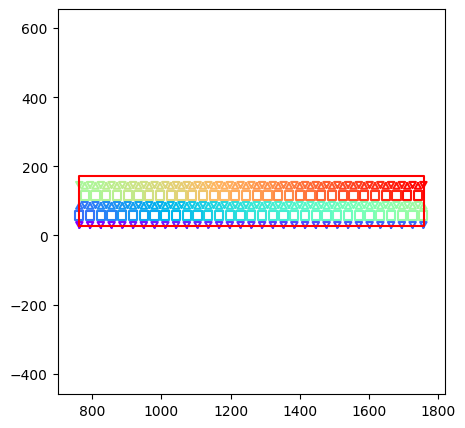

In [23]:
plot_polygon_list(inset_polygon_list + [centered_frame])

## Creating a border with margin  

1. We define some bands around the frame

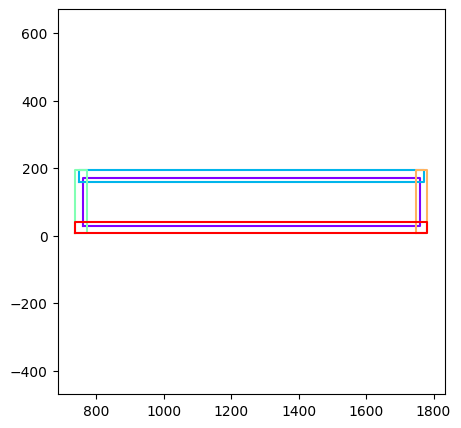

In [24]:
band_width = 12
top_band = polygons([[centered_frame.bounds[0] - band_width, centered_frame.bounds[3] - band_width],
                    [centered_frame.bounds[0] - band_width, centered_frame.bounds[3] + band_width + 10],
                    [centered_frame.bounds[2] + band_width, centered_frame.bounds[3] + band_width + 10],
                    [centered_frame.bounds[2] + band_width, centered_frame.bounds[3] - band_width]])

left_band = polygons([[centered_frame.bounds[0] - band_width - 10, centered_frame.bounds[1] - band_width - 10],
                      [centered_frame.bounds[0] - band_width - 10, centered_frame.bounds[3] + band_width + 10],
                      [centered_frame.bounds[0] + band_width, centered_frame.bounds[3] + band_width + 10],
                      [centered_frame.bounds[0] + band_width, centered_frame.bounds[1] - band_width - 10]])

right_band = polygons([[centered_frame.bounds[2] - band_width, centered_frame.bounds[1] - band_width - 10],
                      [centered_frame.bounds[2] - band_width, centered_frame.bounds[3] + band_width + 10],
                      [centered_frame.bounds[2] + band_width + 10, centered_frame.bounds[3] + band_width + 10],
                      [centered_frame.bounds[2] + band_width + 10, centered_frame.bounds[1] - band_width - 10]])

bottom_band = polygons([[centered_frame.bounds[0] - band_width - 10, centered_frame.bounds[1] - band_width - 10],
                        [centered_frame.bounds[0] - band_width - 10, centered_frame.bounds[1] + band_width],
                        [centered_frame.bounds[2] + band_width + 10, centered_frame.bounds[1] + band_width],
                        [centered_frame.bounds[2] + band_width + 10, centered_frame.bounds[1] - band_width - 10]])

plot_polygon_list([centered_frame, top_band, left_band, right_band, bottom_band])

In [25]:
def is_point_inside_rectangle(point, rect):
    """Check if a point is inside a rectangle."""
    x, y = point
    (rx1, ry1, rx2, ry2) = rect.bounds
    return rx1 <= x <= rx2 and ry1 <= y <= ry2

def is_polygon_inside_rectangle(polygon, rect):
    """Check if any vertices of a polygon are inside a rectangle."""
    return any(is_point_inside_rectangle(vertex, rect) for vertex in polygon.exterior.coords)

In [26]:
top_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, top_band)]
left_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, left_band)]
right_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, right_band)]
bottom_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, bottom_band)]

# deduplicate the list of polygons overlapped by each band:
band_polygons = list(set(top_band_polygons + left_band_polygons + right_band_polygons + bottom_band_polygons))
# keep the polygons outside of bands for later:
all_other_polygons = [polygon for polygon in inset_polygon_list if polygon not in band_polygons]

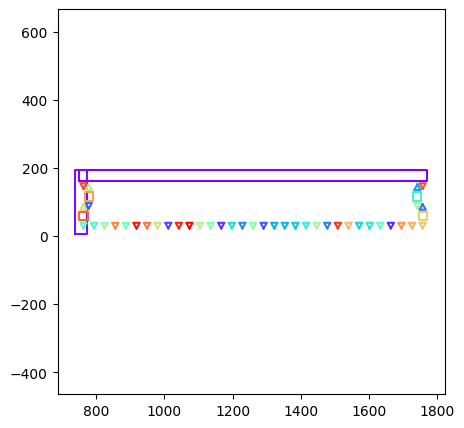

In [27]:
plot_polygon_list([top_band] + [left_band] + band_polygons)

In [28]:
cropped_polygons = []
for poly in band_polygons:
    bit_to_keep_t = poly.difference(top_band)
    bit_to_keep_b = bit_to_keep_t.difference(bottom_band)
    bit_to_keep_l = bit_to_keep_b.difference(left_band)
    bit_to_keep = bit_to_keep_l.difference(right_band)
    cropped_polygons.append(bit_to_keep)


# some polygons are cropped down to nothing (no coordinates), so we need to remove them
cropped_polygons = [poly for poly in cropped_polygons if poly.exterior] 

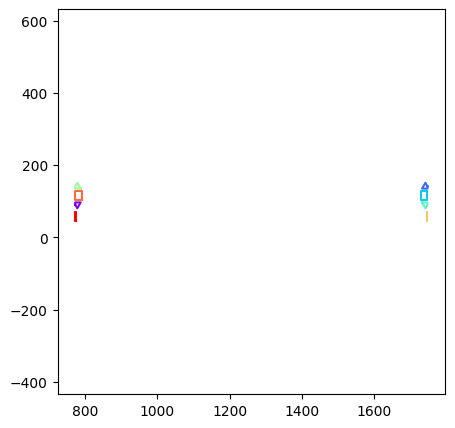

In [29]:
plot_polygon_list(cropped_polygons)

In [30]:
final_polygons =  all_other_polygons + cropped_polygons + [centered_frame]


# SANITY CHECKS

- delete any polygon with an area less than a threshold

In [31]:
len(final_polygons)

192

In [32]:

for poly in final_polygons:
    # pop polygon out of the list if area < 9
    if poly.area < 6:
        final_polygons.remove(poly)
    

In [33]:
len(final_polygons)

192

### Save POLYGONS to SVG

In [34]:
def save_polygon_list_to_svg(polygon_list, filename='semi_regular_hexagon_triangle.svg', size=('1200mm', '300mm')):
    # Create a new SVG drawing
    dwg = svgwrite.Drawing(filename, size=size, profile='full')

    # Create a group for all paths
    group = dwg.g(fill='none', stroke='blue', stroke_width=1)

    # Calculate the maximum y-coordinate to use for flipping
    max_y = max(max(coord[1] for coord in polygon.exterior.coords) for polygon in polygon_list)
    
    # Iterate through the polygons in the list
    for polygon in polygon_list:
        # Extract coordinates from the Shapely polygon, flip the y-coordinate
        coords = [(coord[0], max_y - coord[1]) for coord in polygon.exterior.coords]

        # Create a path
        path = dwg.path(d=f'M {coords[0][0]},{coords[0][1]}')

        # Add line segments to the path
        for coord in coords[1:]:
            path.push(f'L {coord[0]},{coord[1]}')

        # Close the path
        path.push('Z')

        # Add the path to the group
        group.add(path)

    # Add the group to the drawing
    dwg.add(group)

    # Save the drawing
    dwg.save()

# Usage
# Assuming polygon_list is your list of Shapely polygons
# save_polygon_list_to_svg(full_polygon_list + [centered_frame])


### SAVE POLYGONS to SVG with **RESCALING**

In [35]:
def save_polygons_to_svg(polygon_list, filename='tramo2.2.svg', size=('1200mm', '300mm')):
    # Create a new SVG drawing
    dwg = svgwrite.Drawing(filename, size=size, profile='full')

    # Create a group for all paths
    group = dwg.g(fill='none', stroke='blue', stroke_width='0.1px')

    # Calculate the maximum y-coordinate to use for flipping
    max_y = max(max(coord[1] for coord in polygon.exterior.coords) for polygon in polygon_list)

    # Calculate the bounding box of all polygons
    min_x = min(min(coord[0] for coord in polygon.exterior.coords) for polygon in polygon_list)
    max_x = max(max(coord[0] for coord in polygon.exterior.coords) for polygon in polygon_list)
    min_y = min(min(coord[1] for coord in polygon.exterior.coords) for polygon in polygon_list)

    # Calculate scaling factor to fit the drawing in the SVG
    width, height = [float(s.replace('mm', '')) for s in size]
    scale_x = width / (max_x - min_x)
    scale_y = height / (max_y - min_y)
    scale = min(scale_x, scale_y) * 0.9  # 0.9 to leave some margin

    # Iterate through the polygons in the list
    for polygon in polygon_list:
        # Extract coordinates from the Shapely polygon, flip the y-coordinate, scale, and center
        coords = [
            ((coord[0] - min_x) * scale + (width - (max_x - min_x) * scale) / 2,
             (max_y - coord[1]) * scale + (height - (max_y - min_y) * scale) / 2)
            for coord in polygon.exterior.coords
        ]

        # Create a path
        path = dwg.path(d=f'M {coords[0][0]},{coords[0][1]}')

        # Add line segments to the path
        for coord in coords[1:]:
            path.push(f'L {coord[0]},{coord[1]}')

        # Close the path
        path.push('Z')

        # Add the path to the group
        group.add(path)

    # Add the group to the drawing
    dwg.add(group)

    # Save the drawing
    dwg.save()




# SAVE


In [36]:
save_polygons_to_svg(final_polygons)

In [37]:
save_polygon_list_to_svg(final_polygons, filename='tabica_2.1.svg')